## Correlated feature extraction
Imagine we have 15 features observed over multiple rows. We are not sure which ones are most correlated. Instead of testing all pairs, we can build a pyramid with 1, 2, 4, 8, ... and so on blocks, and for simplicity we can define this pyramid simply as a set of ranges operating over the observation vector `v`. In the case of a 4 tier pyramid, these ranges are [1,1] [2,3], [4,7] and [8,15]. We flow information through the pyramid by rotating the input vector a total of 15 times, taking the mean of each row in the pyramid, and storing the composition of elements on that row for which the row registers its maximum value over this set of permutations. We then intersect these compositions to locate common elements.

Note that in this example features spaced more than 8 elements apart cannot be combined. Therefore we re-run the model a second time, having first split it in half and realigned the elements, such that it now has the composition: [1,8,2,9,3,10, ...] Alternatively, we build a pyramid whose base is at least as wide as `f`, the number of features. We repeat over further observations of the same set of features, and can create a pdf of the results.

In [6]:
url = f"https://raw.githubusercontent.com/dunedinsoftware/dunedinsoftware.github.io/main/data_loader.py"
!wget --no-cache --backups=0 {url}

url = f"https://raw.githubusercontent.com/dunedinsoftware/dunedinsoftware.github.io/main/cache.py"
!wget --no-cache --backups=0 {url}

!mkdir data

url = f"https://raw.githubusercontent.com/dunedinsoftware/dunedinsoftware.github.io/main/data/$GSPC.csv"
!wget --no-cache --backups=0 {url} -O "data/$GSPC.csv"


--2022-06-01 17:48:05--  https://raw.githubusercontent.com/dunedinsoftware/dunedinsoftware.github.io/main/data_loader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8895 (8.7K) [text/plain]
Saving to: ‘data/data_loader.py’

data/data_loader.py 100%[===================>]   8.69K  --.-KB/s    in 0.003s  

2022-06-01 17:48:05 (2.64 MB/s) - ‘data/data_loader.py’ saved [8895/8895]



101


Text(0.5, 1.0, 'Relative return vs. percentage days invested')

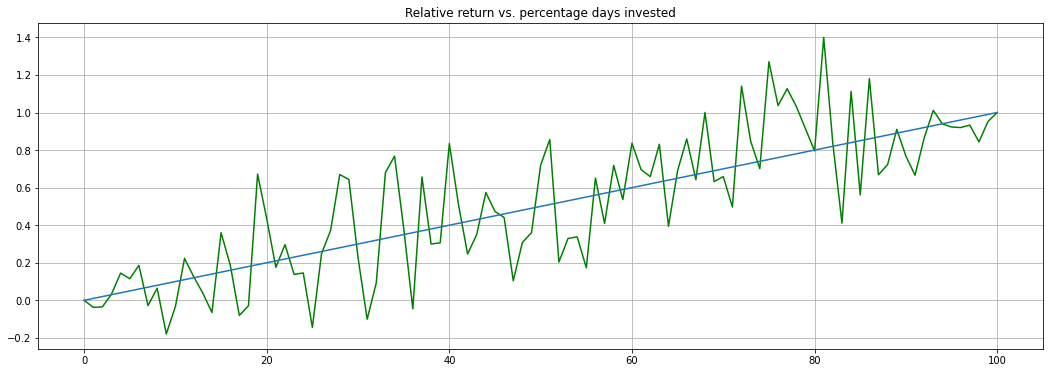

In [4]:
import random
from data_loader import data_file_loader
import numpy as np
import matplotlib.pyplot as plt

def run(path):
  dfl = data_file_loader({"path": path})
  comparison = []
  arithmetic_index_return = np.sum([dfl.series[dt]["next_delta"] for dt in dfl.s_dates])
  for i in range(101):
    sampled_dates = random.sample(dfl.s_dates, int((len(dfl.s_dates) * i)/100))
    comparison.append({"sample_pct": i, "rel_return": np.sum([dfl.series[dt]["next_delta"] for dt in sampled_dates]) / arithmetic_index_return})
  return comparison

results = run("data/$GSPC.csv")
print(len(results))
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([q["sample_pct"] for q in results], [q["rel_return"] for q in results], color="green")
ax1.plot([i for i in range(101)], [i/100 for i in range(101)])
ax1.set_title("Relative return vs. percentage days invested")



In [23]:
def trendiness(path):
  dfl = data_file_loader({"path": path})
  returns = [dfl.series[dt]["prev_delta"] for dt in dfl.s_dates] 
  print("%s, trendiness: %.2f%%" % (path, 100*abs(np.sum(returns)) / np.sum([abs(q) for q in returns])))

trendiness("SP100/data/$GSPC.csv")
trendiness("Indices/data/$RUT.csv")


SP100/data/$GSPC.csv, trendiness: 4.90%
Indices/data/$RUT.csv, trendiness: 4.07%


We'll call this "trendiness." I'll use quotation marks because you may already have preconceptions about something called trend (what it means, what its assumptions are, how predictable it is), while I need to build this up from first principles. Trendiness is simply the absolute directional movement of a price series over a period of time t as a percentage of its total absolute movement over consecutive data points in t, and here we are calculating it over a large time range.

OK, so we've extracted a single statistic from GSPC. How informative is this for an investment decision? Well, in isolation it tells us that mean reverting strategies are likely to outperform momentum strategies over time. For the opposite to be the case, we would need a trendiness reading of more than 50%.

Something we CAN do is calculate trendiness for different stocks or indices. Some may trend more than others, and if we find two with a large difference in trendiness, there's the potential here for a kind of long/short strategy in which we trade the more trending instrument in line with and the less trending instrument against their immediate period direction. 

We can also calculate

Text(0.5, 1.0, 'MR percentage by period')

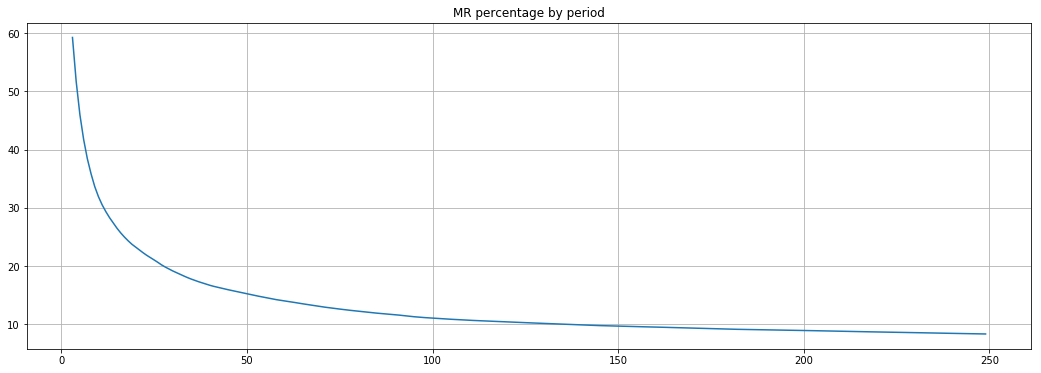

In [22]:
def trendiness_by_period(path):
  dfl = data_file_loader({"path": path})
  mrs = {}
  for period in range(3, 250):
    print("Period: %d   /r" % period, end="")
    mrs[period] = []
    for i in range(period, len(dfl.s_dates)):
      returns = [dfl.series[dt]["prev_delta"] for dt in dfl.s_dates[i-period:i]]
      mrs[period].append(100*abs(np.sum(returns)) / np.sum([abs(q) for q in returns]))    
  return mrs

results = trendiness_by_period("SP100/data/$GSPC.csv")
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([q for q in sorted(results.keys())], [np.mean(results[q]) for q in sorted(results.keys())])
ax1.set_title("Trendiness percentage by period")



Text(0.5, 1.0, 'Percentage recovery by period')

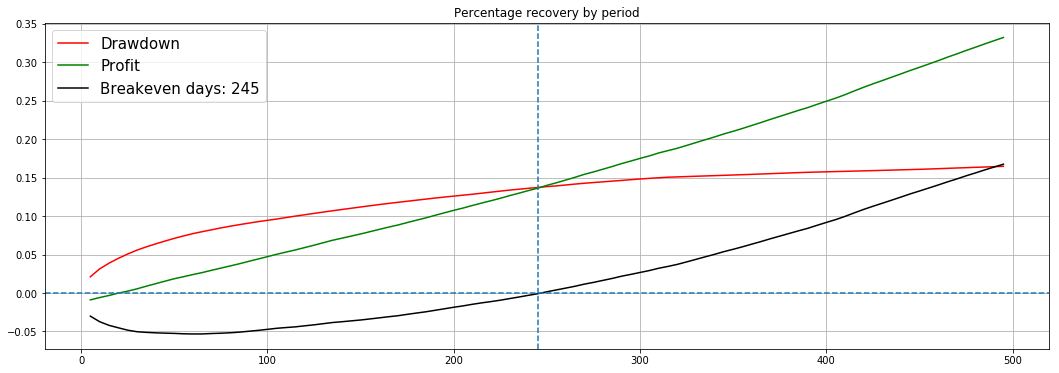

In [65]:
from data_loader import data_file_loader
import numpy as np
import matplotlib.pyplot as plt
import os

def recovery_by_period(path):
  cache_path = "recovery_by_period-%s.npy" % path.replace("/", "_")
  results = np.load(cache_path, allow_pickle=True).tolist() if os.path.exists(cache_path) else {}
  if results == {}:
    dfl, results = data_file_loader({"path": path}), {}
    for period in range(5, 500, 5):
      results[period] = {"drawdown": [], "pl": []}
      for i in range(period, len(dfl.s_dates)):
        min_val, open_val, close_val = min([dfl.series[q]["close"] for q in dfl.s_dates[i-period:i]]), dfl.series[dfl.s_dates[i-period]]["close"], dfl.series[dfl.s_dates[i-1]]["close"] 
        if min_val < open_val:
          results[period]["drawdown"].append(1.0 - (min_val / open_val))
          results[period]["pl"].append((close_val / open_val) - 1.0)           
    np.save(cache_path, results)
  return results

results = recovery_by_period("SP100/data/HD.csv")
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([q for q in sorted(results.keys())], [np.mean(results[q]["drawdown"]) for q in sorted(results.keys())], color="red")
ax1.plot([q for q in sorted(results.keys())], [np.mean(results[q]["pl"]) for q in sorted(results.keys())], color="green")
ax1.plot([q for q in sorted(results.keys())], [np.mean(results[q]["pl"]) - np.mean(results[q]["drawdown"]) for q in sorted(results.keys())], color="black")
cut_off = sorted(results.keys(), key = lambda q: abs(np.mean(results[q]["pl"]) - np.mean(results[q]["drawdown"])))[0]
ax1.axhline(0, linestyle="dashed")
ax1.axvline(cut_off, linestyle="dashed")
ax1.legend(["Drawdown", "Profit", "Breakeven days: %d" % cut_off], fontsize="15")
ax1.set_title("Percentage recovery by period")


Points of interest: the kink in the black line around t=25. This indicates there is actual a *sub-optimal* holding period which maximises the difference between the maximum drawdown expected over the period and the final profit attained at the period's end.

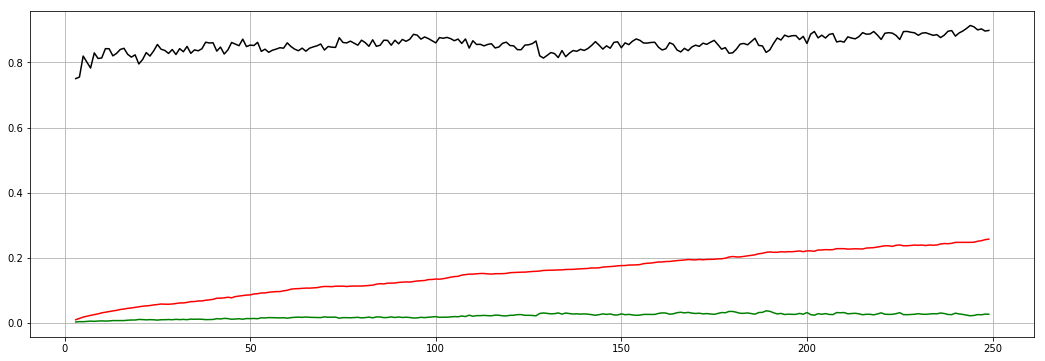

In [74]:
# For a holding period t where the proportion of samples that experienced a drawdown greater than (unspecified) d1
# is alpha, and of which the proportion of such samples that at t that now have a drawdown less than (unspecified) d2
# is beta, calculate d1/d2

# Where d1 is the alpha percentile of the worst maximum drawdowns and d2 is the beta percentile of subsequent
# best closing drawdowns, find (d1/d2)-1.0 for all unprofitable holding periods of length t

# Interpretation: 1.0 - (d2/d1) is the percentage recovered; we want to maximise this
def recovery_characteristics(path, alpha, beta):
  cache_path = "recovery_characteristics-%s.%.2f.%.2f.npy" % (path.replace("/", "_"), alpha, beta)
  results = np.load(cache_path, allow_pickle=True).tolist() if os.path.exists(cache_path) else {}
  if results == {}:
    dfl, results = data_file_loader({"path": path}), {}
    for t in range(3, 250):
      windows = [ [dfl.series[dt]["close"] for dt in dfl.s_dates[i-t:i]] for i in range(t, len(dfl.s_dates)) if dfl.series[dfl.s_dates[i-1]]["close"] < dfl.series[dfl.s_dates[i-t]]["close"] ]
      max_drawdowns = [ (w[0] / min(w)) - 1.0 for w in windows ]
      final_drawdowns = [ (w[0] / w[-1]) - 1.0 for w in windows ]
      all = [ {"window": windows[i], "max_drawdown": max_drawdowns[i], "final_drawdown": final_drawdowns[i]} for i in range(len(windows))]
      alpha_cutoff = int(alpha * len(windows))
      d1_samples = sorted(all, key = lambda q: q["max_drawdown"])[0:alpha_cutoff]
      d1 = d1_samples[-1]["max_drawdown"]
      beta_cutoff = int(beta * len(d1_samples))
      d2_samples = sorted(d1_samples, key = lambda q: q["final_drawdown"], reverse=True)[0:beta_cutoff]
      d2 = d2_samples[-1]["final_drawdown"]
      #assert(d1 < 0)
      #assert(d2 < 0)
      #assert(d2 >= d1)
      results[t] = {"d1": d1, "d2": d2}
    np.save(cache_path, results)
  return results

results = recovery_characteristics("SP100/data/OXY.csv", 0.25, 0.75)
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([q for q in sorted(results.keys())], [results[q]["d1"] for q in sorted(results.keys())], color="red")
ax1.plot([q for q in sorted(results.keys())], [results[q]["d2"] for q in sorted(results.keys())], color="green")
ax1.plot([q for q in sorted(results.keys())], [(results[q]["d1"] - results[q]["d2"]) / results[q]["d1"] for q in sorted(results.keys())], color="black")



If ever proof were needed that stock prices do not follow a random walk, the following chart exemplifies that. Given a price window of length t where the most recent entry is the window minimum, we plot the mean returns l periods ahead. If stock prices really did follow a random walk, these mean returns should be randomly distributed about a zero mean. In fact they better resemble an O-U process for lower values of t and flatline for higher values. One possible explanation for this could be that long periods of decline imply the presence of a fundamental factor that doesn't quickly change, while shorter periods imply trading activity around a temporary mispricing. 

Unsuprisingly, we don't notice a similar pattern for stocks making new t-period highs, suggesting that new lows tend to encourage forced liquidation of long positions at unfavourable prices, either for psychological or contractual reasons.

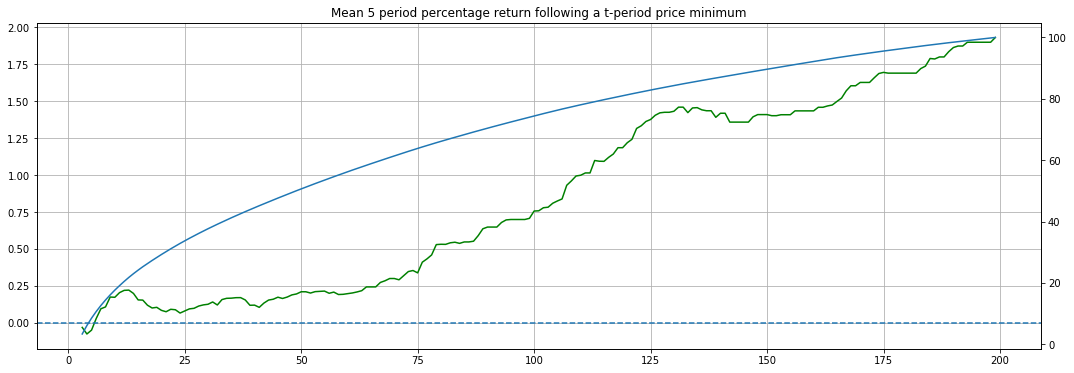

In [130]:
def recovery_characteristics_2(path):
  cache_path, lookahead = "recovery_characteristics_2-%s.npy" % (path.replace("/", "_")), 5
  results = np.load(cache_path, allow_pickle=True).tolist() if os.path.exists(cache_path) else {}
  if results == {}:
    dfl  = data_file_loader({"path": path})
    results = { t : [ (dfl.series[dfl.s_dates[i-1+lookahead]]["close"] / dfl.series[dfl.s_dates[i-1]]["close"]) - 1.0 for i in range(t, len(dfl.s_dates)-lookahead+1) if dfl.series[dfl.s_dates[i-1]]["close"] == min([dfl.series[dt]["close"] for dt in dfl.s_dates[i-t:i]]) ] for t in range(3,200) }
    #results = { t : 100*np.mean([ (dfl.series[dfl.s_dates[i-1+lookahead]]["close"] / dfl.series[dfl.s_dates[i-1]]["close"]) - 1.0 for i in range(t, len(dfl.s_dates)-lookahead+1) if dfl.series[dfl.s_dates[i-1]]["close"] == min([dfl.series[dt]["close"] for dt in dfl.s_dates[i-t:i]]) ]) for t in range(3,200) }
    np.save(cache_path, results)
  return results

results = recovery_characteristics_2("Commodities/data/LE=F.csv")
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([q for q in sorted(results.keys())], [100*np.mean(results[q]) for q in sorted(results.keys())], color="green")
ax1.axhline(0, linestyle="dashed")
ax2 = ax1.twinx()
ax2.plot([q for q in sorted(results.keys())], [100*np.sum([len(results[w]) for w in results.keys() if w <= q]) / np.sum([len(results[w]) for w in results.keys()]) for q in sorted(results.keys())])
ax1.set_title("Mean 5 period percentage return following a t-period price minimum");

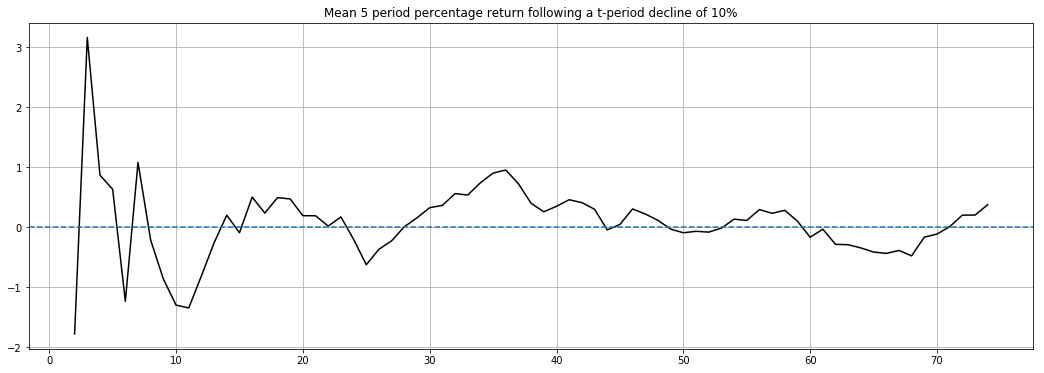

In [107]:
# Compare subsequent performance of a stock that declines x% over different time periods
def period_decline_test(path, target, tolerance):
  cache_path, lookahead = "period_decline_test-%s.%2f.%.2f.npy" % (path.replace("/", "_"), target, tolerance), 5
  results = np.load(cache_path, allow_pickle=True).tolist() if os.path.exists(cache_path) else {}
  if results == {}:
    dfl, results = data_file_loader({"path": path}), {}
    results = { t : 100*np.mean([ (dfl.series[dfl.s_dates[i-1+lookahead]]["close"] / dfl.series[dfl.s_dates[i-1]]["close"]) - 1.0 for i in range(t, len(dfl.s_dates)-lookahead+1) if (dfl.series[dfl.s_dates[i-1]]["close"] / dfl.series[dfl.s_dates[i-t]]["close"]) - 1.0 > -target - tolerance and (dfl.series[dfl.s_dates[i-1]]["close"] / dfl.series[dfl.s_dates[i-t]]["close"]) - 1.0 < -target + tolerance]) for t in range(2,75) }
    np.save(cache_path, results)
  return results

results = period_decline_test("SP100/data/$GSPC.csv", 0.1, 0.03)
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([q for q in sorted(results.keys())], [results[q] for q in sorted(results.keys())], color="black")
ax1.axhline(0, linestyle="dashed")
ax1.set_title("Mean 5 period percentage return following a t-period decline of 10%");

Look at performance lookahead periods ahead after a new t-period low

In [18]:
from data_loader import data_file_loader
import numpy as np

def expected_behaviour(directory, lookahead, standardise_volatility=False):
  min_days, max_days, results = 3, 200, {}
  for symbol in sorted(os.listdir(directory)): # start with the hint directory, to find things we might be interested in
    if not symbol.endswith(".csv"):
      continue
    cache_path = "expected_behaviour-%s.%d.npy" % (symbol, lookahead)
    if not os.path.exists(cache_path):
      print("Generating results for: %s     \r" % symbol, end="")
      dfl = data_file_loader({"path": "%s/%s" % (directory, symbol)})
      series = { t : [ (dfl.series[dfl.s_dates[i-1+lookahead]]["close"] / dfl.series[dfl.s_dates[i-1]]["close"]) - 1.0 for i in range(t, len(dfl.s_dates)-lookahead+1) if dfl.series[dfl.s_dates[i-1]]["close"] == min([dfl.series[dt]["close"] for dt in dfl.s_dates[i-t:i]]) ] for t in range(min_days,max_days) }
      np.save(cache_path, series)
  for symbol in sorted(os.listdir(directory)): # start with the hint directory, to find things we might be interested in
    if not symbol.endswith(".csv"):
      continue
    cache_path = "expected_behaviour-%s.%d.npy" % (symbol, lookahead)
    series = np.load(cache_path, allow_pickle=True).tolist() if os.path.exists(cache_path) else {}
    dfl = data_file_loader({"path": "%s/%s" % (directory, symbol)})
    stdd = np.std([dfl.series[q]["prev_delta"] for q in dfl.s_dates])
    for window_len in range(max_days-1, min_days-1, -1): # find highest period low for today
      window = [dfl.series[dt]["close"] for dt in dfl.s_dates[-window_len:]]
      if window[-1] == min(window): # if p is a period low, then so is p-1, so calculate weighted average over all min_days < t <= p  
        v, total_weight = 0, 0
        for i in range(min_days, window_len+1):
          weight = len(series[i])
          v += (np.mean(series[i]) * weight) if not standardise_volatility else ( (np.mean(series[i]) / stdd) * weight ) # normalise wrt. volatility
          total_weight += weight
        results[symbol] = 100 * v / total_weight
        break
  return results


Samples: 100, correlation: 0.85


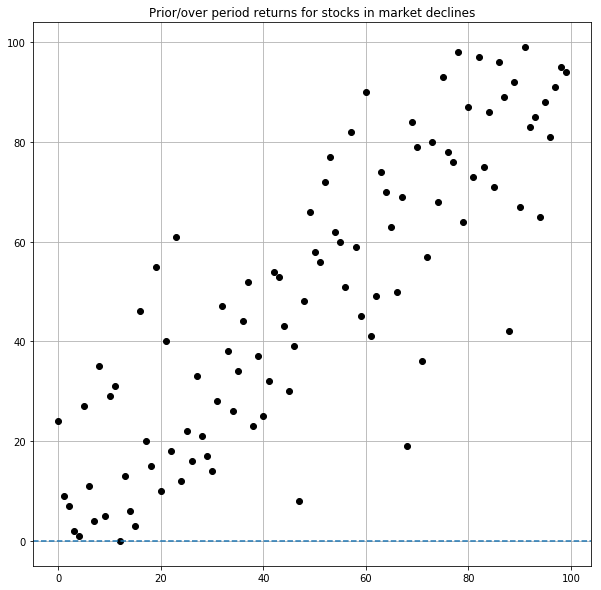

In [19]:
results = fallers_investigation("SP100/data", "$GSPC.csv", 20)
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([q["x_rank"] for q in results], [q["y_rank"] for q in results], "o", color="black")
ax1.axhline(0, linestyle="dashed")
ax1.set_title("Prior/over period returns for stocks in market declines");

Mean rank of all stocks relative to their 100-period prices

Last date: 2021-07-22 00:00:00, 58.34


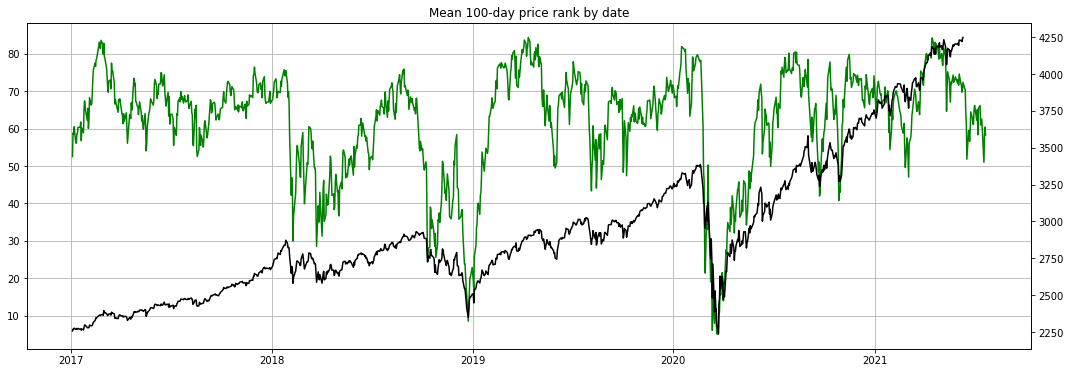

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from data_loader import data_file_loader

def get_mean_rank(source_directory):
  results, days = {}, 100
  for symbol in sorted(os.listdir("%s" % source_directory)): # start with the hint directory, to find things we might be interested in
    if not symbol.endswith(".csv"):
      continue
    print("Processing: %s    \r" % symbol, end="")
    dfl = data_file_loader({"path": "%s/%s" % (source_directory, symbol)})
    for i in range(days-1, len(dfl.s_dates)):
      dt, prices = dfl.s_dates[i], sorted([dfl.series[dt]["close"] for dt in dfl.s_dates[i-days+1:i+1]])
      if dt not in results.keys():
        results[dt] = []
      results[dt].append({"rank": prices.index(dfl.series[dt]["close"]), "next_delta": dfl.series[dt]["next_delta"]})
  for k in results.keys():
    results[k] = {"rank": np.mean([q["rank"] for q in results[k]]), "next_delta": np.mean([q["next_delta"] for q in results[k]])}
  return results

results = get_mean_rank("model_set")
results = { dt : results[dt] for dt in results.keys() if dt.year > 2016 }
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([dt for dt in sorted(results.keys())], [results[dt]["rank"] for dt in sorted(results.keys())], color="green")
ax1.set_title("Mean 100-day price rank by date");
ax2 = ax1.twinx()
dfl = data_file_loader({"path": "SP100/data/$GSPC.csv"})
dates = [dt for dt in sorted(dfl.s_dates) if dt in results.keys()]
prices = [dfl.series[dt]["close"] for dt in dates]
ax2.plot(dates, prices, color="black")
last_dt = max(results.keys())
print("Last date: %s, %.2f" % (last_dt, results[last_dt]["rank"]))
#lb, ub = 50, 75
#for dt in results.keys():
#  v = results[dt]["rank"]  
#  if v < lb:
#    ax1.axvline(dt, color="green")
#  if v > ub:
#    ax1.axvline(dt, color="red")


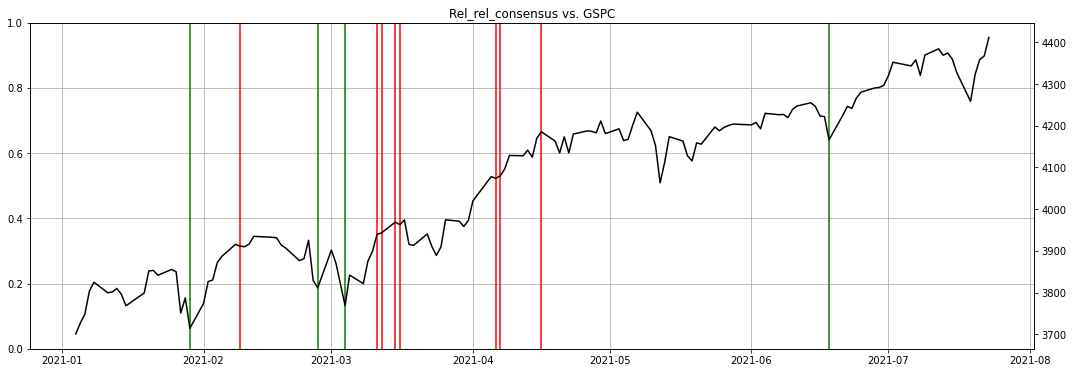

In [34]:
import matplotlib.pyplot as plt
import os
import numpy as np
from data_loader import data_file_loader

def chart_rel_rel_consensus(directory):
  dfl_gspc = data_file_loader({"path": "Indices/data/$GSPC.csv"})
  scenarios_file_path = "scenarios-%s.npy" % directory.replace("/", "_")
  results = np.load(scenarios_file_path, allow_pickle=True).tolist()
  all_rel_consensus = sorted(results.keys(), key = lambda dt: results[dt]["rel_consensus"]) # sort date keys on rel_consensus
  for k in results.keys():
    r_rel_consensus = 0
    while r_rel_consensus < len(all_rel_consensus) and results[all_rel_consensus[r_rel_consensus]]["rel_consensus"] < results[k]["rel_consensus"]:
      r_rel_consensus += 1
    results[k]["rel_rel_consensus"] = r_rel_consensus / len(all_rel_consensus)
  return results

results = chart_rel_rel_consensus("model_set")
results = { dt: results[dt] for dt in results.keys() if dt.year == 2021 }
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
#ax1.plot([dt for dt in sorted(results.keys())], [results[dt]["rel_rel_consensus"] for dt in sorted(results.keys())], color="red")
ax1.set_title("Rel_rel_consensus vs. GSPC");
ax2 = ax1.twinx()
dfl = data_file_loader({"path": "Indices/data/$GSPC.csv"})
s_dates = sorted([dt for dt in results.keys() if dt in dfl.s_dates])
ax2.plot(s_dates, [dfl.series[dt]["close"] for dt in s_dates], color="black")
lb, ub = 0.1, 0.9
for dt in s_dates:
  v = results[dt]["rel_rel_consensus"]  
  if v < lb:
    ax1.axvline(dt, color="red")
  if v > ub:
    ax1.axvline(dt, color="green")



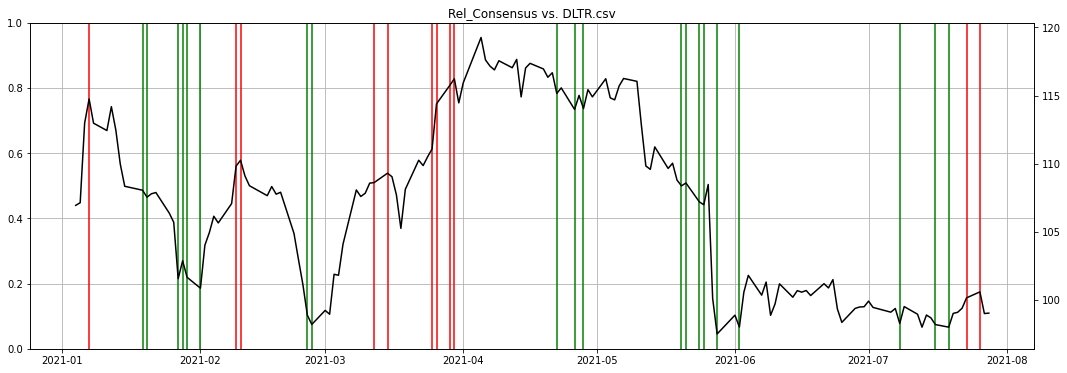

In [56]:
import matplotlib.pyplot as plt
import os
import numpy as np
from data_loader import data_file_loader

def load_models(path):
  return np.load(path, allow_pickle=True).tolist()

directory = "model_set"
symbol = "DLTR.csv"
model_set_file = "%s/%s-model_set.v2.npy" % (directory, symbol)
model_set = load_models(model_set_file)
dfl = data_file_loader({"path": "%s/%s" % (directory, symbol)}, force=True) # always load latest data, in case we decided to drop a date
for dt in model_set["traded_dates"].keys():
  model_set["traded_dates"][dt]["consensus"] = np.sum(model_set["traded_dates"][dt]["signal"]) / np.sum([abs(q) for q in model_set["traded_dates"][dt]["signal"]])
for dt in model_set["traded_dates"].keys():
  rel_consensus = sorted([model_set["traded_dates"][q]["consensus"] for q in model_set["traded_dates"] if q <= dt])
  model_set["traded_dates"][dt]["rel_consensus"] = rel_consensus.index(model_set["traded_dates"][dt]["consensus"]) / len(rel_consensus)

s_dates = sorted([dt for dt in model_set["traded_dates"] if dt.year == 2021])
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
#ax1.plot(s_dates, [model_set["traded_dates"][dt]["consensus"] for dt in s_dates], color="red")
ax1.set_title("Rel_Consensus vs. %s" % symbol);
ax2 = ax1.twinx()
ax2.plot(s_dates, [dfl.series[dt]["close"] for dt in s_dates], color="black")
lb, ub = 0.1, 0.95
for dt in s_dates:
  v = model_set["traded_dates"][dt]["rel_consensus"]  
  if v < lb:
    ax1.axvline(dt, color="red")
  if v > ub:
    ax1.axvline(dt, color="green")



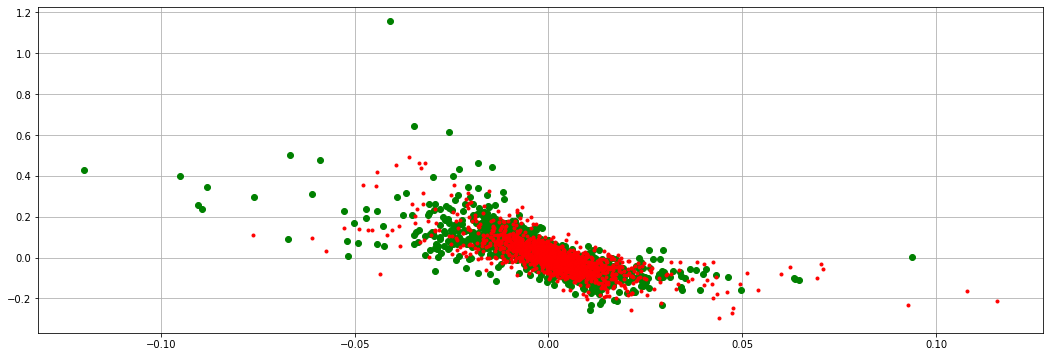

In [21]:
import matplotlib.pyplot as plt
import os
import numpy as np
from data_loader import data_file_loader

tolerance = 0
dfl_vix = data_file_loader({"path": "model_set/$VIX.csv"}, force=False)
dfl_gspc = data_file_loader({"path": "model_set/$GSPC.csv"}, force=False)
s_dates = [dt for dt in dfl_vix.s_dates if dt in dfl_gspc.s_dates]
normal_band = [(dfl_gspc.series[dt]["prev_delta"], dfl_vix.series[dt]["prev_delta"]) for dt in s_dates if dfl_gspc.series[dt]["next_delta"] > tolerance]
critical_band = [(dfl_gspc.series[dt]["prev_delta"], dfl_vix.series[dt]["prev_delta"]) for dt in s_dates if dfl_gspc.series[dt]["next_delta"] < tolerance]

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([q[0] for q in normal_band], [q[1] for q in normal_band], "o", color="green")
ax1.plot([q[0] for q in critical_band], [q[1] for q in critical_band], ".", color="red")
                           
                            
                            

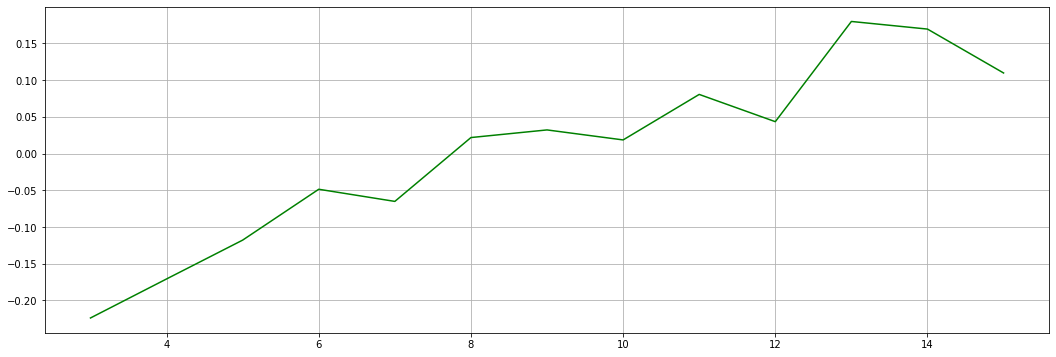

In [15]:
# comparing rel_consensus over all securities against subsequent mean GSPC return
import matplotlib.pyplot as plt
import numpy as np

directory = "model_set"
scenarios_file_path = "scenarios-%s.npy" % directory.replace("/", "_")
results = np.load(scenarios_file_path, allow_pickle=True).tolist()
quantiles = { q : [] for q in range(0,21) }
for dt in results.keys():
  quantile = int(results[dt]["rel_consensus"] * 20)
  quantiles[quantile].append(results[dt]["gspc_next_delta"])
x = sorted(quantiles.keys())[:-5]
y = [100*np.mean(quantiles[q]) for q in x]
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot(x, y, color="green")
                         
            

## Extract mean time to profit

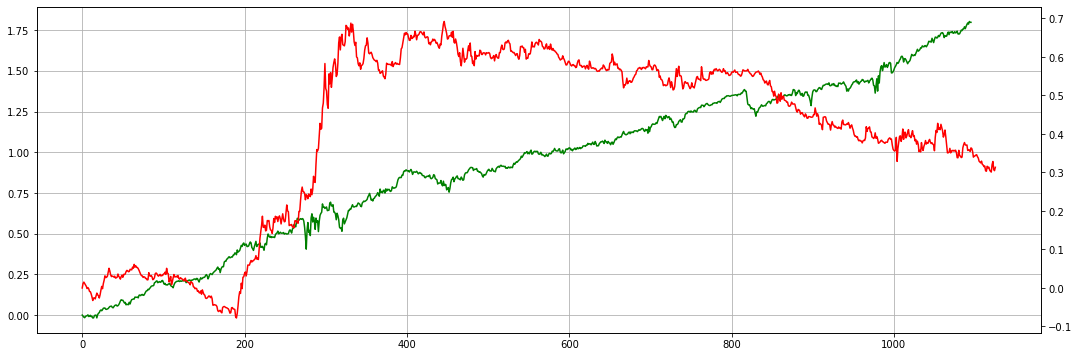

In [24]:

from data_loader import data_file_loader
import numpy as np
import os
import matplotlib.pyplot as plt

def extract_data(dfl, dt, max_window_len = 10000):
  if dt not in dfl.s_dates: # skip if no data for this security for the specified date
    return 0
  j, v = dfl.dtoi[dt], dfl.series[dt]["prev_delta"] # today's delta
  indices = [i for i in range(max(j-max_window_len, 0), j) if dfl.series[dfl.s_dates[i]]["prev_delta"] <= v] # indices of deltas < 0
  c = 0 if len(indices) < 2 else np.mean([indices[i] - indices[i-1] for i in range(1, len(indices))]) # mean days diff between indices
  indices = [i for i in range(max(j-max_window_len, 0), j) if dfl.series[dfl.s_dates[i]]["prev_delta"] > v] # indices of deltas > 0
  c -= 0 if len(indices) < 2 else np.mean([indices[i] - indices[i-1] for i in range(1, len(indices))]) # mean days diff between indices
  return c

def run(directory, index_symbol, use_just_index, proxy):
  cut_off, max_window_len = 0.25, 500
  x_long, x_short, ranked, data_sets = [0], [0], [], { symbol: data_file_loader({"path": "%s/%s" % (directory, symbol)}, force=False) for symbol in sorted(os.listdir(directory)) if symbol.endswith(".csv") and (not use_just_index or symbol == index_symbol) }
  proxy = data_file_loader({"path": "%s/%s" % (directory, proxy)}, force=False)
  for dt in data_sets[index_symbol].s_dates:
    print("%s\r" % dt, end="")
    v = np.mean([extract_data(data_sets[k], dt, max_window_len) for k in data_sets.keys()]) # mean coefficient for dt over all data sets
    ranked = sorted(ranked + [v])
    rank, delta = float(ranked.index(v)) / len(ranked), proxy.series[dt]["next_delta"]
    if rank > 0.5 + cut_off:
      x_long.append(x_long[-1] + delta)
    elif rank < 0.5 - cut_off:
      x_short.append(x_short[-1] - delta)
    #print("Long pl: %.2f (accuracy: %.2f), short pl: %.2f (accuracy: %.2f)" % (np.sum(x_long), 0 if len(x_long) == 0 else float(len([q for q in x_long if q > 0])) / len(x_long), np.sum(x_short), 0 if len(x_short) == 0 else float(len([q for q in x_short if q < 0])) / len(x_short)))
  fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
  ax1.grid(b=True, which="major", axis="both")
  ax1.plot([i for i in range(len(x_long))], x_long, color="green")
  ax2 = ax1.twinx()
  ax2.plot([i for i in range(len(x_short))], x_short, color="red")

index_symbol = "$GSPC.csv"
run("model_set_2", index_symbol, True, index_symbol)


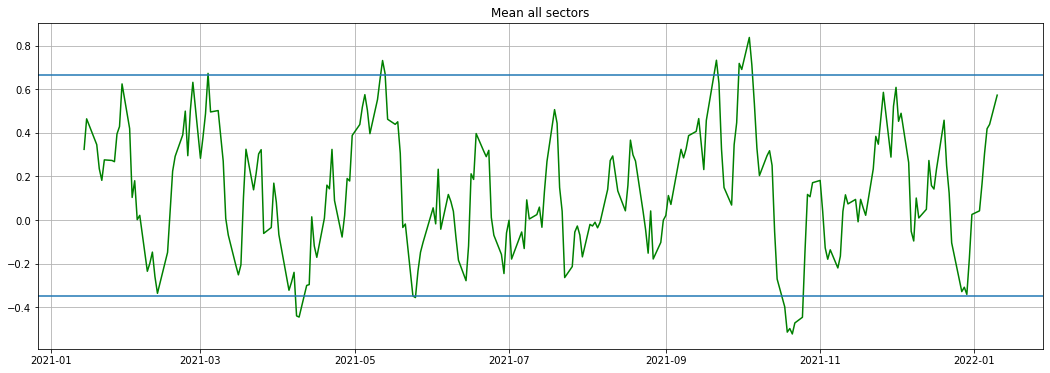

In [31]:
import os, shutil, random
import numpy as np
from data_loader import data_file_loader
import datetime
import matplotlib.pyplot as plt

def create_or_update_consensus_cache_equities(directory, today_dt=None, update_dir={}):
  # load sectors
  cache_file_path = "sectors-%s.npy" % directory.replace("/", "_")
  sectors = {} if not os.path.exists(cache_file_path) else np.load(cache_file_path, allow_pickle=True).tolist()
  sectors = { symbol + ".csv" : sectors[symbol] for symbol in sectors.keys() }
  # prepare results
  results, cache_path = {}, "cache-consensus-%s-equities.npy" % (directory.replace("/", "_"))
  if os.path.exists(cache_path):
    results = np.load(cache_path, allow_pickle=True).tolist()
  else:
    for model_set_path in [q for q in sorted(os.listdir(directory)) if q.endswith("-model_set.v2.npy")]:      
      model_set = np.load("%s/%s" % (directory, model_set_path), allow_pickle=True).tolist()
      symbol = model_set_path.split('-')[0]
      for dt in model_set["traded_dates"].keys():
        if dt not in results.keys():
          results[dt] = { "sectors": {}, "stocks": {}}
        results[dt]["stocks"][symbol] = (np.sum(model_set["traded_dates"][dt]["signal"]) / np.sum([abs(q) for q in model_set["traded_dates"][dt]["signal"]]))
        if symbol in sectors.keys():
          if sectors[symbol] not in results[dt]["sectors"]:
            results[dt]["sectors"][sectors[symbol]] = []
          results[dt]["sectors"][sectors[symbol]].append(results[dt]["stocks"][symbol])
    np.save(cache_path, results)
  if today_dt:
    results[today_dt] = {"sectors": { sector : [update_dir[symbol] for symbol in update_dir.keys() if symbol in sectors.keys() and sectors[symbol] == sector] for sector in set([sectors[q] for q in sectors.keys()])}, "stocks": update_dir}
    np.save(cache_path, results)
  return results

def visualise(directory):
  sectors = ["Consumer Cyclical", "Technology", "Real Estate", "Industrials", "Healthcare", "Utilities", "Financial Services", "Consumer Defensive"]
  sector = sectors[1]
  results = create_or_update_consensus_cache_equities(directory)
  dates = sorted(results.keys())
  vals = [np.mean(results[dt]["sectors"][sector]) for dt in dates]
  cut_off_pct = 0.07 # 5 percent
  tail_elems = int(len(vals) * cut_off_pct)
  s_vals = sorted(vals)
  low_lim = s_vals[tail_elems]
  high_lim = s_vals[-tail_elems]
  sample_dates = dates[-250:]
  sample_vals = vals[-250:]
  fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
  ax1.grid(b=True, which="major", axis="both")
  ax1.plot(sample_dates, sample_vals, color="green")
  ax1.axhline(low_lim)
  ax1.axhline(high_lim)
  #ax1.plot(dates, [np.mean([np.mean(results[dt]["sectors"][s]) for s in sectors]) for dt in dates], color="red")
  ax1.set_title("Mean all sectors")

visualise("model_set_2")

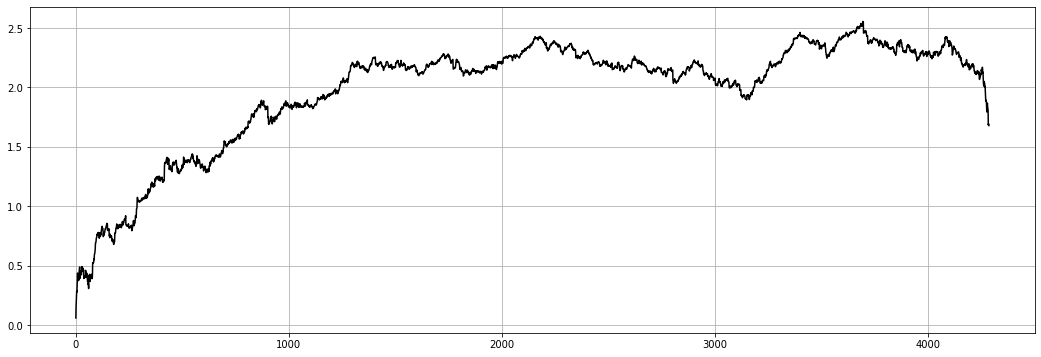

In [9]:

import os, shutil, random
import numpy as np
from data_loader import data_file_loader
import datetime
import matplotlib.pyplot as plt

def run(directory, symbol):
  dfl = data_file_loader({"path": "%s/%s" % (directory, symbol)})
  s_deltas = sorted(dfl.s_dates, key = lambda q: dfl.series[q]["prev_delta"]) # sorted on prev_delta
  y, ya = 0, []
  for dt in s_deltas:
    y += dfl.series[dt]["next_delta"]
    ya.append(y)
  return ya

data = run("model_set_2", "$GSPC.csv")
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax1.grid(b=True, which="major", axis="both")
ax1.plot([i for i in range(len(data))], data, color="black")